In [26]:
import tensorflow as tf
from tensorflow import keras
from sklearn.feature_extraction.text import CountVectorizer
import nltk
import pickle
import numpy as np
from nltk.stem import PorterStemmer 
from nltk.lm import Vocabulary
from nltk.tag import StanfordNERTagger, pos_tag
import glob
import contractions
import enchant
import string
import bs4 as bs
import pandas as pd
from collections import Counter
import urllib.request
import re
import multiprocessing
import ndjson
from gensim.models import Word2Vec
import ssl
from google.cloud import storage
import spacy
from spacy import displacy
import en_core_web_sm
nlp = en_core_web_sm.load()

from sklearn.utils import shuffle
from sklearn import linear_model
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split

from tensorflow.python.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras.models import model_from_json
from tensorflow.python.keras.layers import Sequential, Dense, Dropout, Flatten, Activation, MaxPooling2D, Conv2D, GlobalAveragePooling2D, Bidirectional, LSTM
from tensorflow.python.keras.optimizers import Adam
from tensorflow.python.keras.callbacks import EarlyStopping
from tensorflow.python.keras.metrics import categorical_accuracy
from tensorflow.python.keras.utils import to_categorical
from tensorflow.python.keras import backend as K


%load_ext autotime
import matplotlib.pyplot as plt
%matplotlib inline
print(tf.__version__)

np.random.seed(7)

import warnings
warnings.filterwarnings('ignore')

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

import os

device = 'w'

gpath = 'C:/Users/Ani/Desktop/NLP_project/key.json'
ngram_size = 3

if device=='m':
    gpath = '/Users/animallya/Desktop/NLP_project/key.json'

os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = gpath

ImportError: cannot import name 'Sequential' from 'tensorflow.python.keras.layers' (/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/tensorflow_core/python/keras/layers/__init__.py)

time: 588 ms


In [9]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 6103662811534310380
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 7335348851890556729
physical_device_desc: "device: XLA_CPU device"
]
time: 1.91 ms


In [10]:
def embed(corpus):
    sentences = nltk.sent_tokenize(' '.join(corpus))
    all_words = [nltk.word_tokenize(sent) for sent in sentences]
    for i in range(len(all_words)):
        all_words[i] = [w for w in all_words[i] if w not in stopwords.words('english') and w not in string.punctuation]
    model = Word2Vec(all_words, min_count=3, workers=multiprocessing.cpu_count())
    return model
#embeddings = embed(corpus)

time: 1.1 ms


In [11]:
import sqlite3
import pandas as pd

def filter_words(text, global_vocab):
    words = []
    for w in text:
        w = w.lower()
        if len(w)>1:
            if global_vocab.check(w)==True:
                words.append(w)
            elif '\'' in w or '’' in w:
                if contractions.fix(w) != w:
                    fixedw = contractions.fix(w).lower()
                    words.append(fixedw)
        else:
            if w in['i','a']:
                words.append(w)
    return ' '.join(words)

def message_scrape(path, n):
    
    conn = sqlite3.connect(path)
    c = conn.cursor()
    cmd1 = 'SELECT ROWID, text, handle_id, \
                datetime(date + strftime(\'%s\',\'2001-01-01\'), \'unixepoch\') as date_utc \
                FROM message T1 \
                INNER JOIN chat_message_join T2 \
                    ON T2.chat_id='+str(n)+ ' \
                    AND T1.ROWID=T2.message_id \
                ORDER BY T1.date'
    c.execute(cmd1)
    df_msg = pd.DataFrame(c.fetchall(), columns=['id', 'text', 'sender', 'time'])
    corpus = df_msg.text.tolist()
    corpus = ' '.join(corpus)
    corpus = re.sub('[^a-zA-Z\'\’]', ' ', corpus)
    corpus = re.sub(r'\s+', ' ', corpus)
    corpus = corpus.lower().split(" ")
    filtered_corpus = filter_words(corpus, enchant.Dict("en_US"))
    return filtered_corpus

time: 3.64 ms


## Trigram prediction model (continuous Deep Learning)

In [12]:
def preprocess(id, flatten=True, fit=False, vocab=None, vectorizer=None):
    
    corpus = message_scrape(path='/Users/animallya/Desktop/chat.db',n=id)
    words = nltk.word_tokenize(corpus)
    
    if id==2:
    #automate this later
        words = list(filter(lambda a: a != 'bet', words))

    if fit:
        vocab = list(Vocabulary(words))
        vectorizer = CountVectorizer(vocabulary=vocab)
        vectorizer.fit(words)

    Y = [vocab.index(words[i]) for i in range(ngram_size, len(words))]
    if flatten == True:
        X = [vectorizer.transform(words[i-ngram_size:i]).toarray().flatten() for i in range(ngram_size, len(words))] 
    else:
        X = [vectorizer.transform(words[i-ngram_size:i]).toarray().astype('float64') for i in range(ngram_size, len(words))]
    Y = [to_categorical(y,len(vocab)) for y in Y]
    X, Y = shuffle(X, Y, random_state=42)
    
    return np.array(X),np.array(Y), words, vocab, vectorizer

time: 5.16 ms


In [13]:
X,y,words,vocab,vectorizer = preprocess(2, fit=True)

time: 2.04 s


In [14]:
sequence_model =  MLPClassifier(n_iter_no_change =2, verbose=1, activation='tanh', learning_rate='constant', alpha=1e-4, random_state=1, warm_start='full') #picked 60 as limit because it overfits after
sequence_model.fit(X,y)

Iteration 1, loss = 821.26472405
Iteration 2, loss = 275.67954904
Iteration 3, loss = 65.68074354
Iteration 4, loss = 31.02450583
Iteration 5, loss = 20.46419954
Iteration 6, loss = 15.64937666
Iteration 7, loss = 13.02183910
Iteration 8, loss = 11.42457564
Iteration 9, loss = 10.37947008
Iteration 10, loss = 9.65697767


MLPClassifier(activation='tanh', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100,), learning_rate='constant',
              learning_rate_init=0.001, max_iter=200, momentum=0.9,
              n_iter_no_change=2, nesterovs_momentum=True, power_t=0.5,
              random_state=1, shuffle=True, solver='adam', tol=0.0001,
              validation_fraction=0.1, verbose=1, warm_start='full')

time: 15.8 s


In [27]:
def bidirectional_lstm_model():
    print('Build LSTM model.')
    model = Sequential()
    model.add(Bidirectional(LSTM(512, dropout=0.1,
                     recurrent_dropout=0.5,
                     activation="relu",input_shape=(ngram_size, len(vocab)))))
    model.add(Dense(len(vocab),activation='softmax'))
    callbacks=[EarlyStopping(patience=2, monitor='val_loss')]
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=[categorical_accuracy])
    print("model built!")
    return model

time: 1.52 ms


In [28]:
rnn_model = bidirectional_lstm_model()
X,y,_,_,_ = preprocess(2, flatten=False,vocab=vocab,vectorizer=vectorizer)
history_rnn = rnn_model.fit(X, y, batch_size=32, shuffle=True, epochs=30)

Build LSTM model.
model built!
Train on 8867 samples
Epoch 1/30
8867/8867 [==============================] - 57s 6ms/sample - loss: 6.2236 - categorical_accuracy: 0.0429
Epoch 2/30
8867/8867 [==============================] - 50s 6ms/sample - loss: 5.8278 - categorical_accuracy: 0.0461
Epoch 3/30
8867/8867 [==============================] - 49s 6ms/sample - loss: 5.6277 - categorical_accuracy: 0.0715
Epoch 4/30
8867/8867 [==============================] - 49s 6ms/sample - loss: 5.2383 - categorical_accuracy: 0.1043
Epoch 5/30
8867/8867 [==============================] - 51s 6ms/sample - loss: 4.7593 - categorical_accuracy: 0.1449
Epoch 6/30
8867/8867 [==============================] - 52s 6ms/sample - loss: 4.2299 - categorical_accuracy: 0.1881
Epoch 7/30
8867/8867 [==============================] - 51s 6ms/sample - loss: 3.6244 - categorical_accuracy: 0.2473
Epoch 8/30
8867/8867 [==============================] - 51s 6ms/sample - loss: 3.0087 - categorical_accuracy: 0.3229
Epoch 9/30


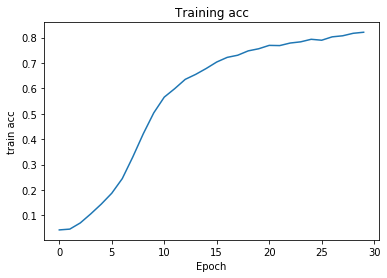

time: 216 ms


In [72]:
#plt.plot(sequence_model.loss_curve_)
plt.plot(history_rnn.history['categorical_accuracy'])
plt.title('Training acc')
plt.ylabel('train acc')
plt.xlabel('Epoch')
plt.show()

In [205]:
def update_model(id, model, flatten=False):
    #corpus = web_scrape(urls)
    X,y,words,corpus,_,_ = preprocess(id)
    history=None
    if flatten==False:
        history = model.fit(X,y, batch_size=32, shuffle=True, epochs=10)
    else:
        model.fit(X,y)
    print("fit complete")

    return words, history

time: 1.69 ms


In [206]:
#sequence_model, updated_words, = update_model(['Natural_language_processing'], sequence_model, flatten=True)
updated_words, _ = update_model(6, sequence_model, flatten=True)
updated_words, history_update1 = update_model(6, rnn_model)

Iteration 201, loss = 8.20567273
fit complete
Train on 4338 samples, validate on 483 samples
Epoch 1/10
4338/4338 [==============================] - 27s 6ms/sample - loss: 5.9315 - categorical_accuracy: 0.0735 - val_loss: 5.3611 - val_categorical_accuracy: 0.1139
Epoch 2/10
4338/4338 [==============================] - 27s 6ms/sample - loss: 4.9808 - categorical_accuracy: 0.1213 - val_loss: 5.1672 - val_categorical_accuracy: 0.1222
Epoch 3/10
4338/4338 [==============================] - 35s 8ms/sample - loss: 4.6418 - categorical_accuracy: 0.1498 - val_loss: 5.1080 - val_categorical_accuracy: 0.1222
Epoch 4/10
4338/4338 [==============================] - 35s 8ms/sample - loss: 4.3935 - categorical_accuracy: 0.1660 - val_loss: 5.0822 - val_categorical_accuracy: 0.1201
Epoch 5/10
4338/4338 [==============================] - 38s 9ms/sample - loss: 4.1854 - categorical_accuracy: 0.1842 - val_loss: 5.0602 - val_categorical_accuracy: 0.1201
Epoch 6/10
4338/4338 [==============================

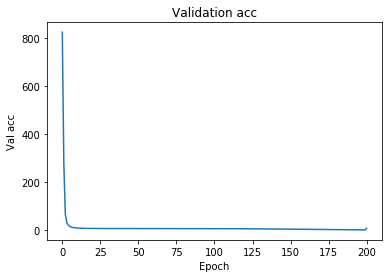

time: 204 ms


In [207]:
plt.plot(sequence_model.loss_curve_)
plt.title('Validation acc')
plt.ylabel('Val acc')
plt.xlabel('Epoch')
plt.show()

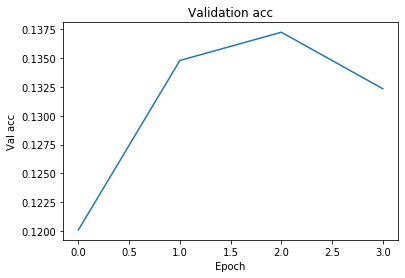

time: 439 ms


In [48]:
plt.plot(history_update1.history['val_categorical_accuracy'])
plt.title('Validation acc')
plt.ylabel('Val acc')
plt.xlabel('Epoch')
plt.show()

## Pos-tagging using trigram max-ent model

In [24]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

#corpus = web_scrape([''])
#encoding sets of 3 tags into flattened vector that's one-hot encoded
doc = nlp(' '.join(words))
label_encoder = LabelEncoder()
onehot_encoder = OneHotEncoder(sparse=False)

xtemp = [token.tag_ for token in doc]
encoded = label_encoder.fit_transform(xtemp)
#encoded = onehot_encoder.fit_transform(int_encoded.reshape(len(int_encoded), 1))

X_encoded = []
y_encoded = []

for i in range(ngram_size,len(encoded)):
    x_encoded = encoded[i-ngram_size:i]
    X_encoded.append(x_encoded)
    y_encoded.append(encoded[i])
    
y_encoded = np.array(y_encoded)
X_encoded = np.array(X_encoded)

time: 1.12 s


In [117]:
y_encoded.shape

(8879,)

time: 2.88 ms


In [134]:
#tag_model = linear_model.LogisticRegression(multi_class='multinomial',solver='saga', penalty = 'l1', n_jobs=-1,verbose=2)
from sklearn.svm import SVC
tag_model = SVC(gamma='auto',probability=True, class_weight='balanced')
tag_model.fit(X_encoded, y_encoded)

SVC(C=1.0, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

time: 21.6 s


### Saving all 3 models

In [30]:
def save_model(model, model_name):
    model.save('savefiles/'+model_name+'.h5') 

save_model(rnn_model,'rnn_model')

# filename = 'savefiles/wordMLPpredictor.sav'
# pickle.dump(sequence_model, open(filename, 'wb'))

# filename = 'savefiles/postagger.sav'
# pickle.dump(tag_model, open(filename, 'wb'))

# filename = 'savefiles/rnnModel.sav'
# pickle.dump(rnn_model, open(filename, 'wb'))

time: 160 ms


time: 145 ms


# TESTING


In [19]:
rnn_model = tf.keras.models.load_model('savefiles/rnn_model.h5')
#sequence_model = pickle.load(open('savefiles/wordMLPpredictor.sav','rb'))
#tag_model = pickle.load(open('savefiles/tagmaxent.sav', 'rb'))

time: 582 ms


In [20]:
def input_tag_to_prediction(inp):
    doc = nlp(inp.lower())
    tags = [token.tag_ for token in doc]
    X_encoded = label_encoder.transform(tags)
    #X_encoded = onehot_encoder.transform(integer_encoded.reshape(len(integer_encoded), 1)).flatten()
    y_pred = tag_model.predict_proba(X_encoded.reshape(1, -1))[0]
    indices = (y_pred).argsort()[::-1][:3]
    return [(label_encoder.inverse_transform([idx])[0],y_pred[idx]) for idx in indices]

time: 1.5 ms


In [21]:
def input_word_to_prediction(inp):
    words = nltk.word_tokenize(inp.lower())
    words_tf = np.array(vectorizer.transform(words).toarray()).flatten().reshape(1, -1)
    y_pred = sequence_model.predict_proba(words_tf)[0]
    indices = (y_pred).argsort()[::-1][:3]
    return [(vocab[idx],y_pred[idx])  for idx in indices]

time: 1.42 ms


In [22]:
def rnn_predict(sent):
    words = nltk.word_tokenize(sent.lower())
    x = np.array(vectorizer.transform(words).toarray().astype('float64'))
    words_tf = x.reshape(1,x.shape[0],x.shape[1])
    y_pred = np.array(rnn_model.predict(words_tf)[0])
    print(sorted(y_pred)[::-1][:3])
    indices = (y_pred).argsort()[::-1][:3]
    return [(vocab[idx],y_pred[idx]) for idx in indices]

time: 1.69 ms


In [23]:
def run(sent):
    out = sent
    while True:
        print(out)
        pt = input_tag_to_prediction(sent)
        pw = input_word_to_prediction(sent)
        rw = rnn_predict(sent)
        print(pt)
        print(pw)
        print(rw)
        inp = input()
        if inp=="exit":
            return out
        out+= " " +inp
        l = len(inp.split())
        sent = " ".join(nltk.word_tokenize(sent)[l:]+[inp])
    print(out)

time: 1.5 ms


In [136]:
out = run("why are you")
#i will be home by

why are you
[0.37783977, 0.10629171, 0.093154274]
[('VB', 0.41003595978225027), ('NN', 0.06617040404386372), ('RB', 0.05829251190161947)]
[('working', 0.12829266142528584), ('doing', 0.059137574225196304), ('guys', 0.04474304410396975)]
[('guys', 0.37783977), ('read', 0.10629171), ('at', 0.093154274)]
guys
why are you guys
[0.8875198, 0.08649598, 0.009410029]
[('IN', 0.15941064207923833), ('PRP', 0.12560822446132466), ('NN', 0.11965671664053572)]
[('up', 0.601066267500362), ('at', 0.22628872843766334), ('because', 0.031332649805760844)]
[('up', 0.8875198), ('at', 0.08649598), ('guys', 0.009410029)]
up
why are you guys up
[0.9092717, 0.030605413, 0.02394584]
[('VB', 0.3244325499690234), ('RB', 0.14850091144050406), ('IN', 0.10349533659286643)]
[('to', 0.9440518153142753), ('there', 0.40866143384142906), ('after', 0.05028877778059168)]
[('to', 0.9092717), ('a', 0.030605413), ('there', 0.02394584)]
exit
time: 34.2 s


In [208]:
dev_set = message_scrape(path='/Users/animallya/Desktop/chat.db',n=6)

time: 199 ms


In [138]:
doc = nlp('guys')
print([w.tag_ for w in doc])

['NNS']
time: 10.9 ms


In [104]:
' '.join(words)

'i checked seismic activity might have actually been a small earthquake block min no more office on my mac how do get office now use search spotlight to search for it can not product key worked good glad you found it this messages on mac can not send green texts you have to turn the option yes thinking of posting in a group about gym buddies i feel like i need some folks to join occasionally when is your date right now heading there enjoy see you in class maybe yes posting in hey might be more useful there are only oldies on this one liked posting in hey might be more useful there are only oldies on this one smiling wot none of your damn business why do all these people not want breaks hungry room after class yea you can invite your mother along make sure you can understand this so that for the project we can do a word predictor this stuff is not helping me practical application whatsoever but i am watching some stuff on the side that might help hungry out which genius invented this to

time: 5.25 ms


time: 670 ms


In [153]:
print([w.tag_ for w in doc])
print([w.tag_ for w in pred])

['VBZ', 'DT', 'JJ']
['RB']
time: 964 µs


In [31]:
converter = tf.lite.TFLiteConverter.from_keras_model(rnn_model)
tflite_model = converter.convert()

ConverterError: See console for info.
2019-11-09 16:06:29.371199: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2019-11-09 16:06:29.383389: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f9cdb550780 executing computations on platform Host. Devices:
2019-11-09 16:06:29.383403: I tensorflow/compiler/xla/service/service.cc:175]   StreamExecutor device (0): Host, Default Version
2019-11-09 16:06:29.463751: I tensorflow/lite/toco/import_tensorflow.cc:659] Converting unsupported operation: TensorListFromTensor
2019-11-09 16:06:29.463787: I tensorflow/lite/toco/import_tensorflow.cc:193] Unsupported data type in placeholder op: 21
2019-11-09 16:06:29.463848: I tensorflow/lite/toco/import_tensorflow.cc:659] Converting unsupported operation: TensorListFromTensor
2019-11-09 16:06:29.463854: I tensorflow/lite/toco/import_tensorflow.cc:193] Unsupported data type in placeholder op: 21
2019-11-09 16:06:29.463875: I tensorflow/lite/toco/import_tensorflow.cc:659] Converting unsupported operation: TensorListReserve
2019-11-09 16:06:29.463881: I tensorflow/lite/toco/import_tensorflow.cc:193] Unsupported data type in placeholder op: 21
2019-11-09 16:06:29.463889: I tensorflow/lite/toco/import_tensorflow.cc:659] Converting unsupported operation: TensorListReserve
2019-11-09 16:06:29.463894: I tensorflow/lite/toco/import_tensorflow.cc:193] Unsupported data type in placeholder op: 21
2019-11-09 16:06:29.463924: I tensorflow/lite/toco/import_tensorflow.cc:659] Converting unsupported operation: While
2019-11-09 16:06:29.463939: I tensorflow/lite/toco/import_tensorflow.cc:193] Unsupported data type in placeholder op: 21
2019-11-09 16:06:29.463942: I tensorflow/lite/toco/import_tensorflow.cc:193] Unsupported data type in placeholder op: 21
2019-11-09 16:06:29.463965: I tensorflow/lite/toco/import_tensorflow.cc:659] Converting unsupported operation: While
2019-11-09 16:06:29.463977: I tensorflow/lite/toco/import_tensorflow.cc:193] Unsupported data type in placeholder op: 21
2019-11-09 16:06:29.463980: I tensorflow/lite/toco/import_tensorflow.cc:193] Unsupported data type in placeholder op: 21
2019-11-09 16:06:29.463997: I tensorflow/lite/toco/import_tensorflow.cc:659] Converting unsupported operation: TensorListStack
2019-11-09 16:06:29.464005: I tensorflow/lite/toco/import_tensorflow.cc:659] Converting unsupported operation: TensorListStack
2019-11-09 16:06:29.482122: I tensorflow/lite/toco/graph_transformations/graph_transformations.cc:39] Before Removing unused ops: 48 operators, 133 arrays (0 quantized)
2019-11-09 16:06:29.482371: I tensorflow/lite/toco/graph_transformations/graph_transformations.cc:39] After Removing unused ops pass 1: 46 operators, 131 arrays (0 quantized)
2019-11-09 16:06:29.482877: I tensorflow/lite/toco/graph_transformations/graph_transformations.cc:39] Before general graph transformations: 46 operators, 131 arrays (0 quantized)
2019-11-09 16:06:29.486943: I tensorflow/lite/toco/graph_transformations/graph_transformations.cc:39] After general graph transformations pass 1: 16 operators, 80 arrays (0 quantized)
2019-11-09 16:06:29.487209: I tensorflow/lite/toco/graph_transformations/graph_transformations.cc:39] Before Group bidirectional sequence lstm/rnn: 16 operators, 80 arrays (0 quantized)
2019-11-09 16:06:29.487375: I tensorflow/lite/toco/graph_transformations/graph_transformations.cc:39] Before dequantization graph transformations: 16 operators, 80 arrays (0 quantized)
2019-11-09 16:06:29.487727: I tensorflow/lite/toco/allocate_transient_arrays.cc:345] Total transient array allocated size: 33664 bytes, theoretical optimal value: 33664 bytes.
2019-11-09 16:06:29.488178: E tensorflow/lite/toco/toco_tooling.cc:466] We are continually in the process of adding support to TensorFlow Lite for more ops. It would be helpful if you could inform us of how this conversion went by opening a github issue at https://github.com/tensorflow/tensorflow/issues/new?template=40-tflite-op-request.md
 and pasting the following:

Some of the operators in the model are not supported by the standard TensorFlow Lite runtime. If those are native TensorFlow operators, you might be able to use the extended runtime by passing --enable_select_tf_ops, or by setting target_ops=TFLITE_BUILTINS,SELECT_TF_OPS when calling tf.lite.TFLiteConverter(). Otherwise, if you have a custom implementation for them you can disable this error with --allow_custom_ops, or by setting allow_custom_ops=True when calling tf.lite.TFLiteConverter(). Here is a list of builtin operators you are using: CONCATENATION, FULLY_CONNECTED, RESHAPE, REVERSE_V2, SOFTMAX, STRIDED_SLICE. Here is a list of operators for which you will need custom implementations: TensorListFromTensor, TensorListReserve, TensorListStack, While.
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.7/bin/toco_from_protos", line 8, in <module>
    sys.exit(main())
  File "/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/tensorflow_core/lite/toco/python/toco_from_protos.py", line 89, in main
    app.run(main=execute, argv=[sys.argv[0]] + unparsed)
  File "/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/tensorflow_core/python/platform/app.py", line 40, in run
    _run(main=main, argv=argv, flags_parser=_parse_flags_tolerate_undef)
  File "/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/absl/app.py", line 299, in run
    _run_main(main, args)
  File "/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/absl/app.py", line 250, in _run_main
    sys.exit(main(argv))
  File "/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/tensorflow_core/lite/toco/python/toco_from_protos.py", line 52, in execute
    enable_mlir_converter)
Exception: We are continually in the process of adding support to TensorFlow Lite for more ops. It would be helpful if you could inform us of how this conversion went by opening a github issue at https://github.com/tensorflow/tensorflow/issues/new?template=40-tflite-op-request.md
 and pasting the following:

Some of the operators in the model are not supported by the standard TensorFlow Lite runtime. If those are native TensorFlow operators, you might be able to use the extended runtime by passing --enable_select_tf_ops, or by setting target_ops=TFLITE_BUILTINS,SELECT_TF_OPS when calling tf.lite.TFLiteConverter(). Otherwise, if you have a custom implementation for them you can disable this error with --allow_custom_ops, or by setting allow_custom_ops=True when calling tf.lite.TFLiteConverter(). Here is a list of builtin operators you are using: CONCATENATION, FULLY_CONNECTED, RESHAPE, REVERSE_V2, SOFTMAX, STRIDED_SLICE. Here is a list of operators for which you will need custom implementations: TensorListFromTensor, TensorListReserve, TensorListStack, While.




time: 4.98 s
